In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

import json, os, sys
sys.path.append("../utils")

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

In [2]:
path = os.path.join(os.getcwd(), 'ss_data', "single_shot_1us_164010", "state_after.json")

durations = np.array([0.5, 1, 2, 5, 10])
names     = ["0p5us_164004", "1us_164010", "2us_164016", "5us_164020", "10us_164027"]

def get_IQ_states(folder_name):
    path = os.path.join(os.getcwd(), 'ss_data', f"single_shot_{folder_name}", "state_after.json")

    with open(path) as file:
        data = json.load(file)

    # Get the data
    IQ_state_0 = (
        1   * np.array(data["experiment_results"]["Readout signal (final_I) ss"]["value"])[:, 0] + 
        1j  * np.array(data["experiment_results"]["Readout signal (final_Q) ss"]["value"])[:, 0]
    )

    IQ_state_1 = (
        1   * np.array(data["experiment_results"]["Readout signal (final_I) ss"]["value"])[:, 1]+ 
        1j  * np.array(data["experiment_results"]["Readout signal (final_Q) ss"]["value"])[:, 1])
    
    return {"0": IQ_state_0, "1": IQ_state_1}


IQ_state_0 = []
IQ_state_1 = []
for name in names:
    IQ_states = get_IQ_states(name)
    IQ_state_0.append(IQ_states["0"])
    IQ_state_1.append(IQ_states["1"])
    
IQ_state_0 = np.array(IQ_state_0)
IQ_state_1 = np.array(IQ_state_1)

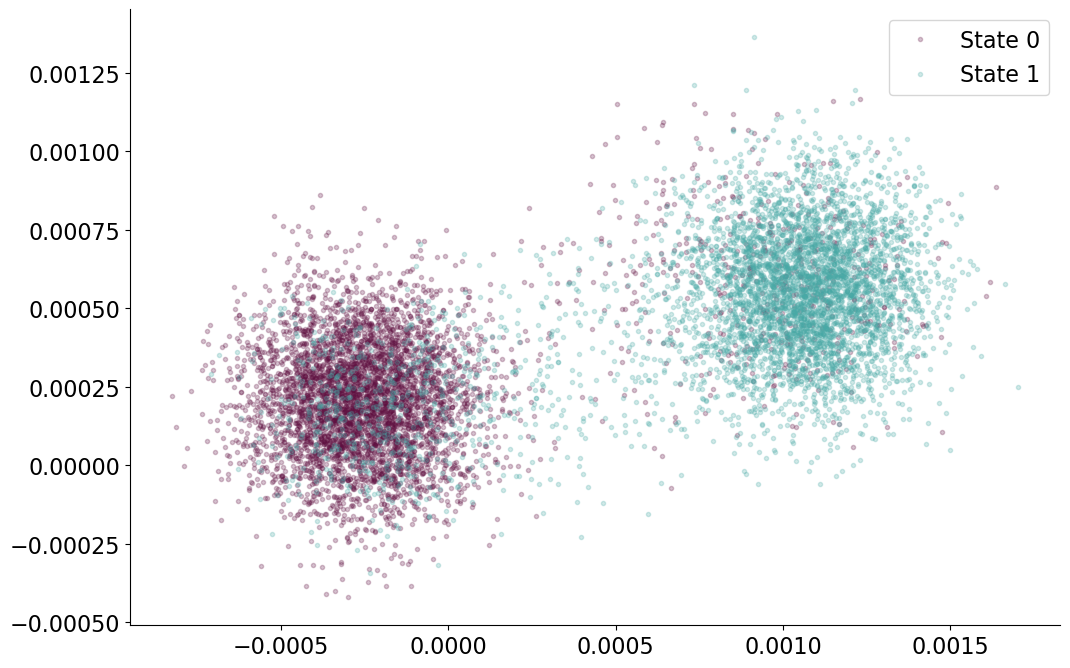

In [3]:
plt.plot(IQ_state_0[1].real, IQ_state_0[1].imag, marker = ".", ls = "none", alpha = 0.25, label="State 0")
plt.plot(IQ_state_1[1].real, IQ_state_1[1].imag, marker = ".", ls = "none", alpha = 0.25, label="State 1")
plt.legend()

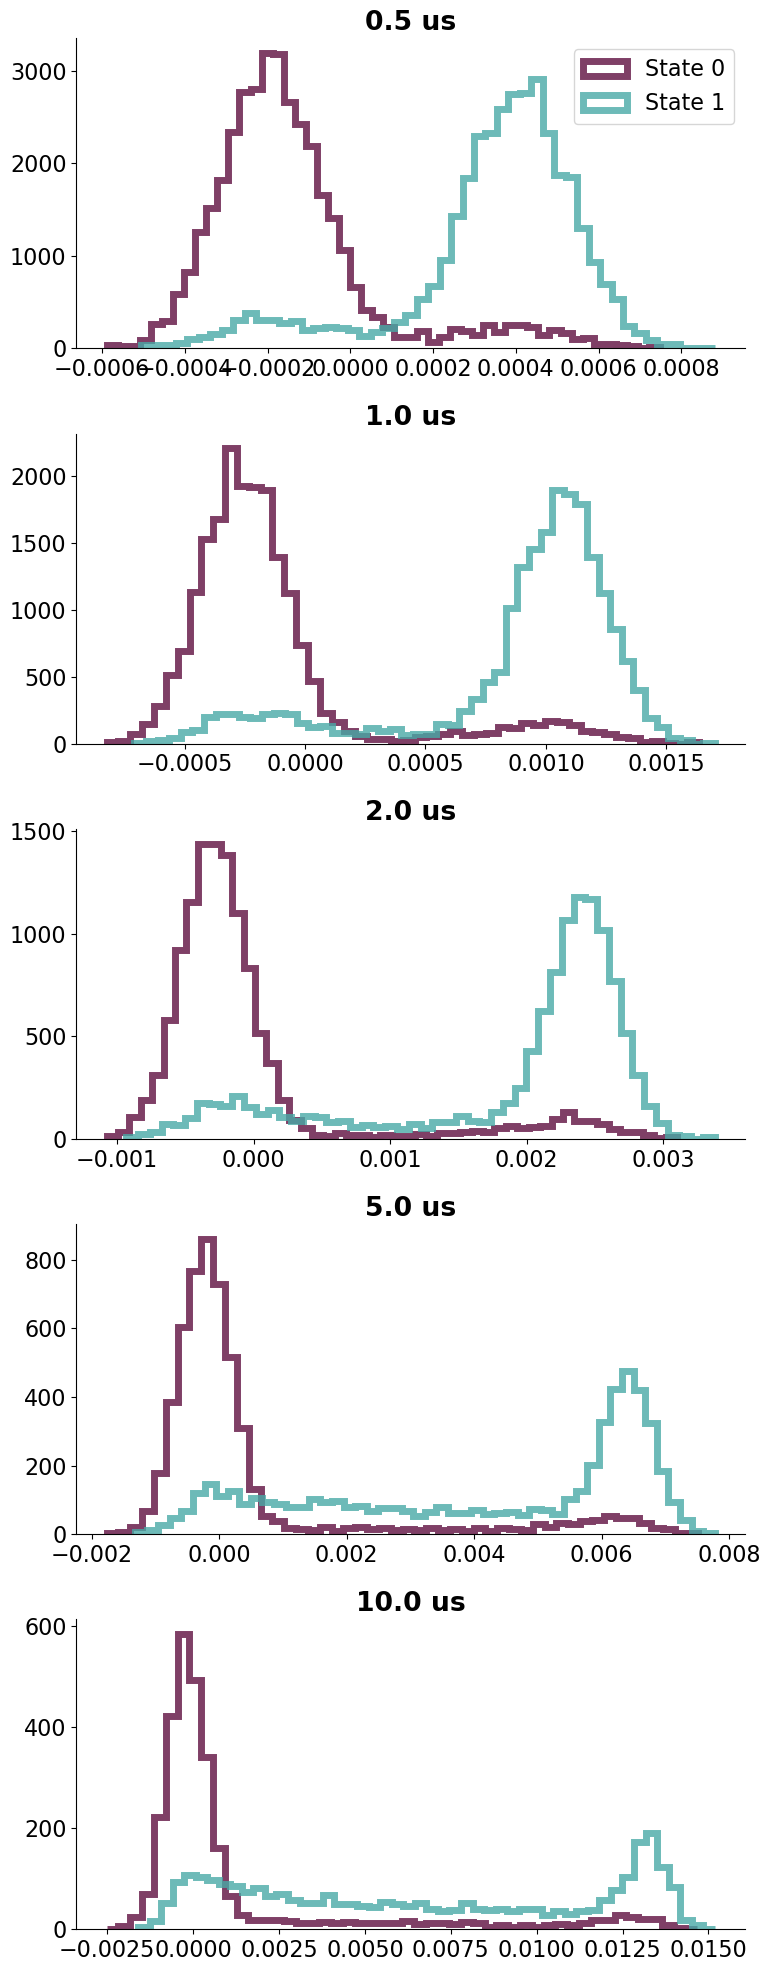

In [4]:
fig, axes = plt.subplots(nrows = len(durations), figsize = (8, 20))

from scipy.stats import norm

for i, ax in enumerate(axes):
    ax.hist(IQ_state_0[i].real, bins= 50, alpha= 0.8, histtype = "step", linewidth = 5, density = True, label="State 0")
    ax.hist(IQ_state_1[i].real, bins= 50, alpha= 0.8, histtype = "step", linewidth = 5, density = True, label="State 1")

    xs = np.linspace(*ax.get_xlim(), 1000)
    norm_params_0 = norm.fit(IQ_state_0[i].real)
    norm_params_1 = norm.fit(IQ_state_1[i].real)
    
    # ax.plot(xs, norm.pdf(xs, *norm_params_0), color = "C0")
    # ax.plot(xs, norm.pdf(xs, *norm_params_1), color = "C1")
    
    
    ax.set_title(f"{durations[i]} us")

axes[0].legend()

fig.tight_layout()

For state 0: 	 Mean: -0.13 mV  	 Std: 0.59 mV
For state 1: 	 Mean: 6.38 mV  	 Std: 0.42 mV


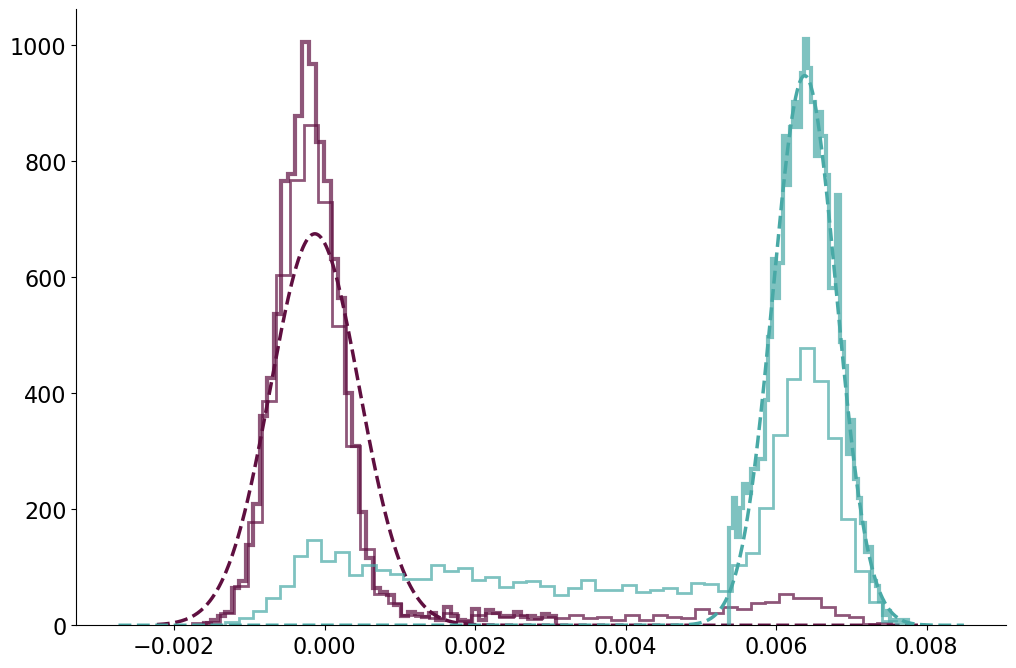

In [51]:
# Plot the two distributions
fig, ax = plt.subplots()
# I_0 = IQ_state_0[0].real 


def get_mean_and_plot(data, quantile = (0.05, 0.95), ax = None, color = None):
    quantiles           = np.quantile(data, quantile)
    within_quantiles    = np.logical_and(quantiles[0] < data, data < quantiles[1])
    limited_data        = data[within_quantiles] 

    params              = norm.fit(limited_data)

    if ax:
        ax.hist(data, bins = 50, alpha = 0.7, histtype = "step", linewidth = 2, density = True, color = color)
        ax.hist(limited_data, bins = 50, alpha = 0.7, histtype = "step", linewidth = 3, density = True, color = color, ls = "-")
        xs = np.linspace(*ax.get_xlim(), 1001)
        ax.plot(xs, norm.pdf(xs, *params), "--", color = color)

    return np.mean(data[within_quantiles]), np.std(data[within_quantiles])



mean_0, std_0 = get_mean_and_plot(IQ_state_0[3].real, quantile = (0.00, 0.90),  ax = ax, color = "C0")
mean_1, std_1 = get_mean_and_plot(IQ_state_1[3].real, quantile = (0.50, 1.00),  ax = ax, color = "C1")


print(f"For state 0: \t Mean: {mean_0 * 1000:.2f} mV  \t Std: {std_0 * 1000:.2f} mV")
print(f"For state 1: \t Mean: {mean_1 * 1000:.2f} mV  \t Std: {std_1 * 1000:.2f} mV")

In [78]:
time    = 5       # us
T1      = 9      # us
steps   = 1001
N       = 5000 * 5

gamma1  = 1 / T1
ts      = np.linspace(0, time, steps)
dt      = ts[1] - ts[0]

start_position = (mean_0 + mean_1) / 2
start_std      = (std_0 + std_1) / 2

distance       = abs(mean_1 - mean_0) / 2
travel_speed   = distance / time

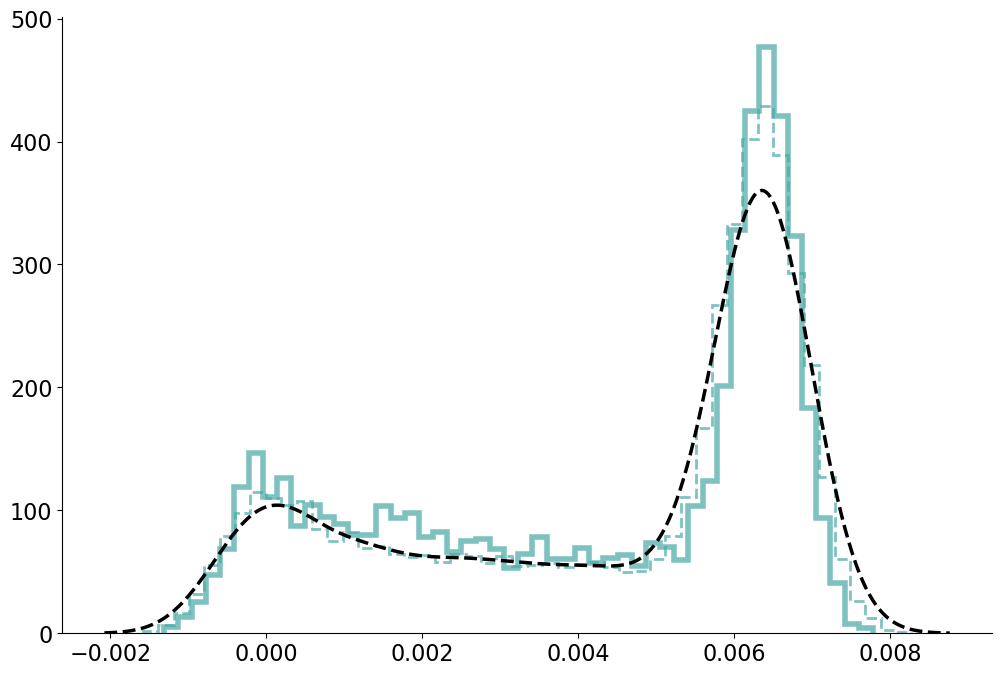

In [80]:
from numba import jit
@jit()
def simulate(T1, initial_flip, time, steps = steps, N = N):
    gamma1 = 1 / T1
    
    # Start params
    ts      = np.linspace(0, time, steps)
    dt      = ts[1] - ts[0]
    I_vals  = np.random.normal(start_position, start_std, N)
    states  = np.ones(N)

    # Initial flip
    flip = np.random.rand(N) < initial_flip
    flip = np.logical_and(flip, states == 1)
    states[flip] = 0
    
    # Simulate
    for t in ts:
        # Check if qubit flips
        flip = np.random.rand(N) < gamma1 * dt

        # Flip the qubit
        flip = np.logical_and(flip, states == 1)
        states[flip] = 0

        # Update the I value
        I_vals += travel_speed * dt * (states - 1 / 2 ) * 2
    
    return I_vals

simulated_data = simulate(T1, 0.10, time, steps = steps, N = N)

fig, ax = plt.subplots()
ax.hist(simulated_data,     bins = 50, alpha = 0.7, histtype = "step", linewidth = 2, density = True, color = "C1", label = "Simulated", ls = "--");
ax.hist(IQ_state_1[3].real, bins = 50, alpha = 0.7, histtype = "step", linewidth = 4, density = True, color = "C1", label = "Measured");


from scipy.stats import gaussian_kde
xs = np.linspace(*ax.get_xlim(), 1001)
ax.plot(xs, gaussian_kde(simulated_data).pdf(xs), "k--")

In [70]:
def simulate_and_nllh(data, T1, initial_flip, time, steps = steps, N = N):
    simulated_data  = simulate(T1, initial_flip, time, steps = steps, N = N)
    gaussian_kernel = gaussian_kde(simulated_data)

    return -np.sum(gaussian_kernel.logpdf(data))

from scipy.optimize import minimize

minimize_func = lambda x: simulate_and_nllh(IQ_state_1[3].real, x[0], x[1], time)


res = minimize(minimize_func, [10, 0.1], bounds = [(15, 20), (0, 0.25)], options = {"maxiter": 50})


In [57]:
scan_range_t1           = np.linspace(1, 10, 10)
scan_range_initial_flip = np.linspace(0, 0.20, 10)

xs, ys = np.meshgrid(scan_range_t1, scan_range_initial_flip)

llh_values = np.zeros_like(xs)

from tqdm import tqdm
for i in tqdm(range(len(scan_range_t1))):
    for j in range(len(scan_range_initial_flip)):
        llh_values[i, j] = simulate_and_nllh(IQ_state_1[3].real, scan_range_t1[i], scan_range_initial_flip[j], time)

100%|██████████| 10/10 [01:46<00:00, 10.67s/it]


In [74]:
scan_range_t1           = np.linspace(17, 18, 11)
# scan_range_initial_flip = [0.10]

llh_values = np.zeros_like(scan_range_t1)

from tqdm import tqdm
for i in tqdm(range(len(scan_range_t1))):
    llh_values[i] = simulate_and_nllh(IQ_state_1[3].real, 0.10, scan_range_initial_flip[j], time)

100%|██████████| 11/11 [01:16<00:00,  6.92s/it]


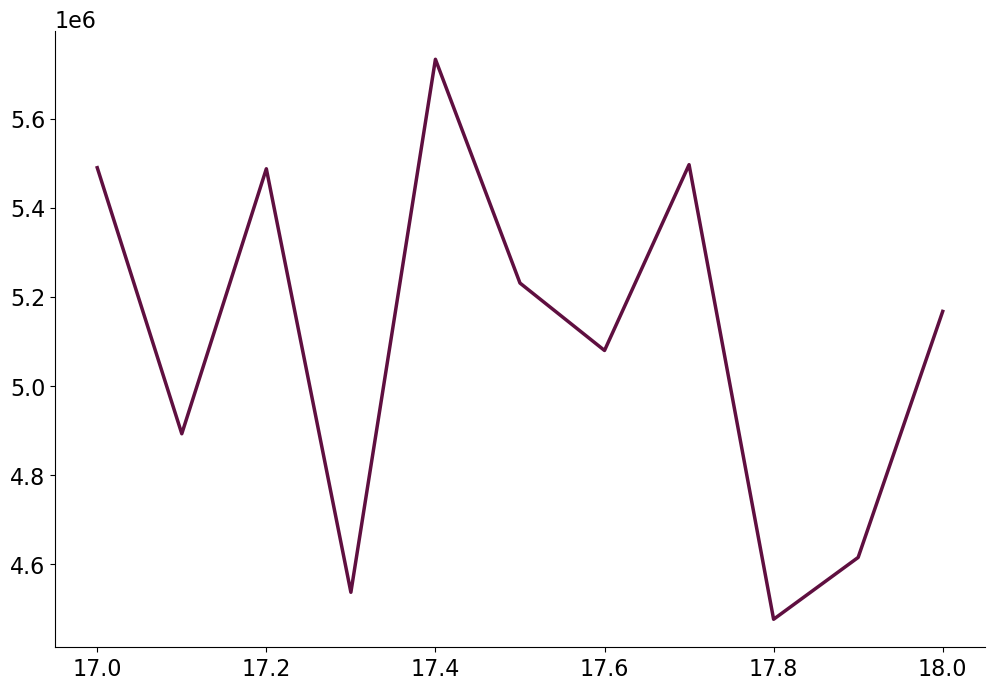

In [75]:
plt.plot(scan_range_t1,  llh_values)

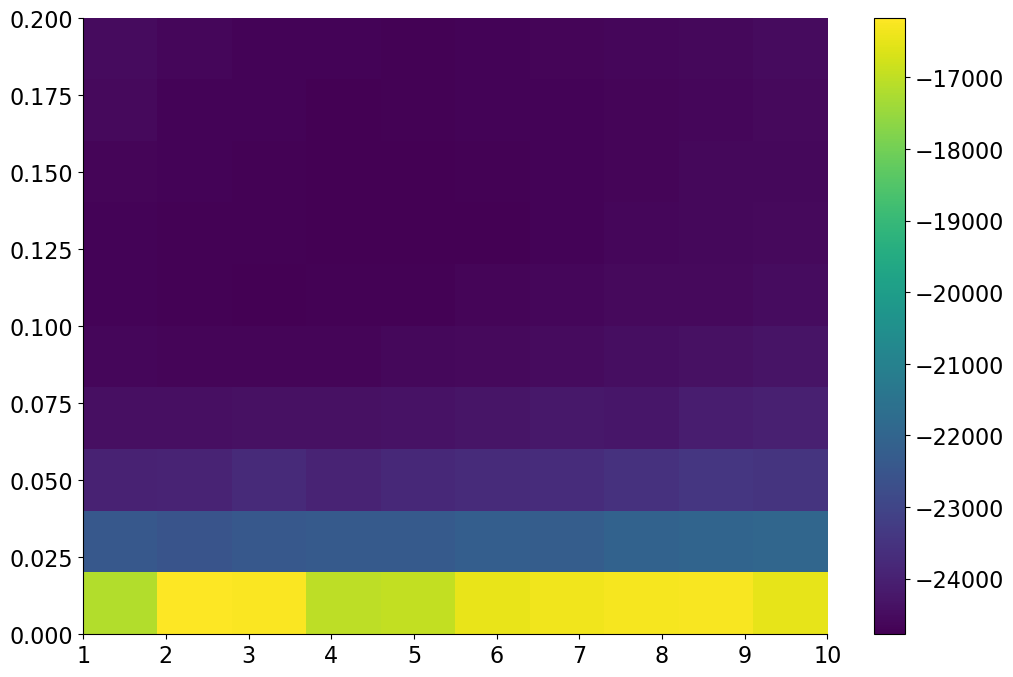

In [58]:
imag = plt.imshow(llh_values, origin = "lower", extent = (scan_range_t1[0], scan_range_t1[-1], scan_range_initial_flip[0], scan_range_initial_flip[-1]), aspect = "auto")
plt.colorbar(imag)

In [ ]:
scan_range = np.linspace(1, 10, 10)
llh_values = np.zeros_like(scan_range)

from tqdm import tqdm
for i in tqdm(range(len(scan_range))):

    llh_values[i] = minimize_func(scan_range[i])


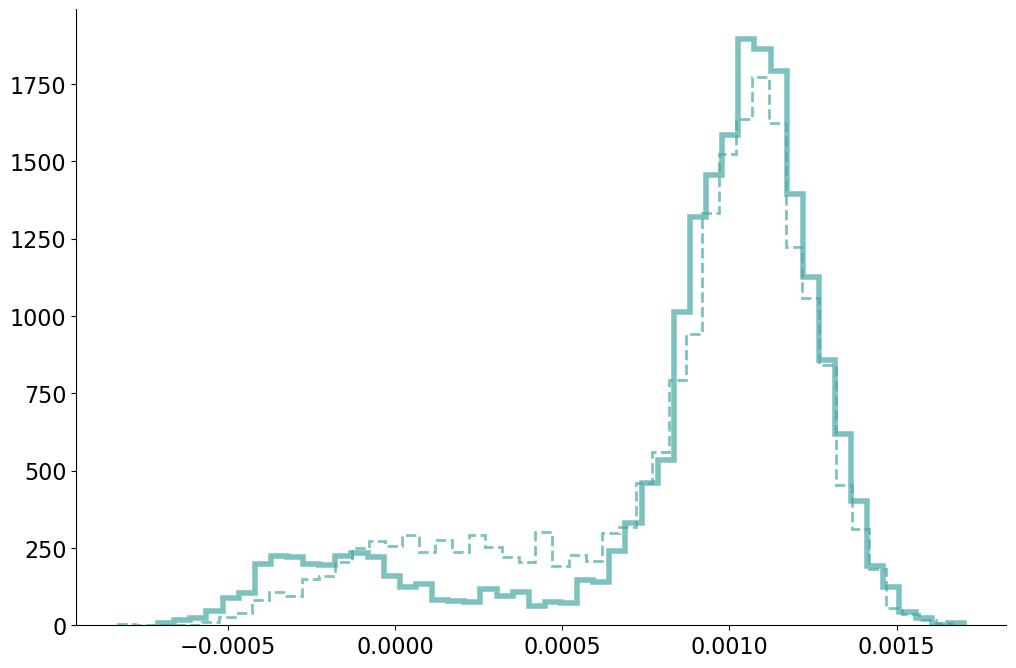

In [121]:
initial_I_value     = np.random.normal(start_position, start_std, N)
initial_qubit_state = np.ones(N)

I_vals = initial_I_value
states = initial_qubit_state

for t in ts:
    # Check if qubit flips
    flip = np.random.rand(N) < gamma1 * dt

    # Flip the qubit
    flip = np.logical_and(flip, states == 1)
    states[flip] = 0

    # Update the I value
    I_vals += travel_speed * dt * (states - 1 / 2 ) * 2

fig, ax = plt.subplots()
ax.hist(I_vals,             bins = 50, alpha = 0.7, histtype = "step", linewidth = 2, density = True, color = "C1", label = "Simulated", ls = "--");
ax.hist(IQ_state_1[1].real, bins = 50, alpha = 0.7, histtype = "step", linewidth = 4, density = True, color = "C1", label = "Measured");
